#### Hierarchical classifiers

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
import pickle as pk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score,
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
import time

In [9]:
with open("x_training.pkl" , "rb") as file:
    x_training = pk.load(file)
with open("y_training.pkl" , "rb") as file:
    y_training = pk.load(file)

#### 1. Data processing  
I need to transform the y vector so that the class 2 becomes class 1 (class 1 will contain prediabetics and diabetics, class 0 remains healthy only)

In [17]:
# transform class 2 in class 1
y_training_first = np.where(y_training <= 1 , y_training , 1)

# checks
print(len(y_training) , len(y_training_first))
print(np.unique(y_training_first))

202945 202945
[0. 1.]


#### 2. Model evaluation
I will evaluate model performances on the new  binary problem.  
I will initially evaluate models looking in particular at recall of unhealthy class.  
Later I will decide the best classifier considering the diabetes and prediabetes recall.

In [22]:
# the HistGradientBoostingClassifier from ImbalanceLearn needs a boolean mask for categorical features

boolean_mask_tot = [False if col == "BMI" or col == "MentHlth" or col == "PhysHlth" else True for col in x_training.columns]

In [47]:
# I will only consider the models that performed well previously

logistic_reg = Pipeline([
    ('scaler', StandardScaler()), 
    ('lgr', LogisticRegression(
        solver="lbfgs", 
        max_iter=500, 
        class_weight="balanced"
    ))
])

hgbc = HistGradientBoostingClassifier(
    random_state = 42,
    class_weight="balanced",
    max_iter=500,
    categorical_features=boolean_mask_tot
)

bal_rfc = BalancedRandomForestClassifier(
    n_estimators = 500,
    replacement=False,
    random_state=42,
    n_jobs=-1    
)

eec = EasyEnsembleClassifier(
    n_estimators = 100,
    replacement=False,
    n_jobs=-1,
    random_state = 42    
)


# create a dictionary to iterate on models
models = {"LogisticRegression" : logistic_reg , "HistGradientBoostingClassifier" : hgbc, "BalancedRandomForest": bal_rfc, "EasyEnsembleClassifier" : eec}

In [30]:
# 10 fold cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [31]:
# define scoring function

def specificity(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

scoring = {
    'recall_disease': 'recall', 
    'recall_healthy': make_scorer(specificity), 
    'mcc': make_scorer(matthews_corrcoef)
}

#### Performance on binary problem

In [32]:
# iterate on models and look at performances
results=[]
names=[]
for name, model in models.items():
        
    start = time.time()
    
    cv_recall = cross_validate(model, x_training, y_training_first, cv=cv, scoring=scoring)
    
    end = time.time()

    mcc_mean = cv_recall['test_mcc'].mean()
    mcc_std  = cv_recall['test_mcc'].std()
    rec_mean = cv_recall['test_recall_disease'].mean()
    rec_std  = cv_recall['test_recall_disease'].std()
    spc_mean = cv_recall['test_recall_healthy'].mean()
    spc_std  = cv_recall['test_recall_healthy'].std()
    
    sep = 35 - len(name)
    print(f"{name}"+"_"*sep+f"    mean mcc         = {mcc_mean:.4f}    std mcc         = {mcc_std:.4f}    time = {((end-start)/60):.2f}")
    print("_"*35+f"    mean recall      = {rec_mean:.4f}    std recall      = {rec_std:.4f}    ")
    print("_"*35+f"    mean specificity = {spc_mean:.4f}    std specificity = {spc_std:.4f}    ")
    print("\n")

    results.append(cv_recall)
    names.append(name)

LogisticRegression_________________    mean mcc         = 0.3698    std mcc         = 0.0047    time = 0.05
___________________________________    mean recall      = 0.7616    std recall      = 0.0038    
___________________________________    mean specificity = 0.7234    std specificity = 0.0032    


HistGradientBoostingClassifier(tot)    mean mcc         = 0.3734    std mcc         = 0.0037    time = 0.25
___________________________________    mean recall      = 0.7886    std recall      = 0.0046    
___________________________________    mean specificity = 0.7066    std specificity = 0.0036    


BalancedRandomForest_______________    mean mcc         = 0.3495    std mcc         = 0.0067    time = 3.02
___________________________________    mean recall      = 0.7750    std recall      = 0.0072    
___________________________________    mean specificity = 0.6911    std specificity = 0.0023    


EasyEnsembleClassifier_____________    mean mcc         = 0.3673    std mcc         = 0.

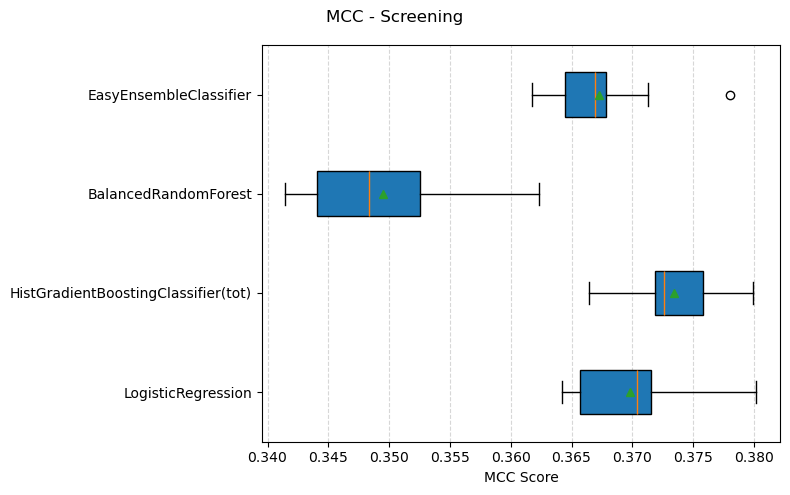

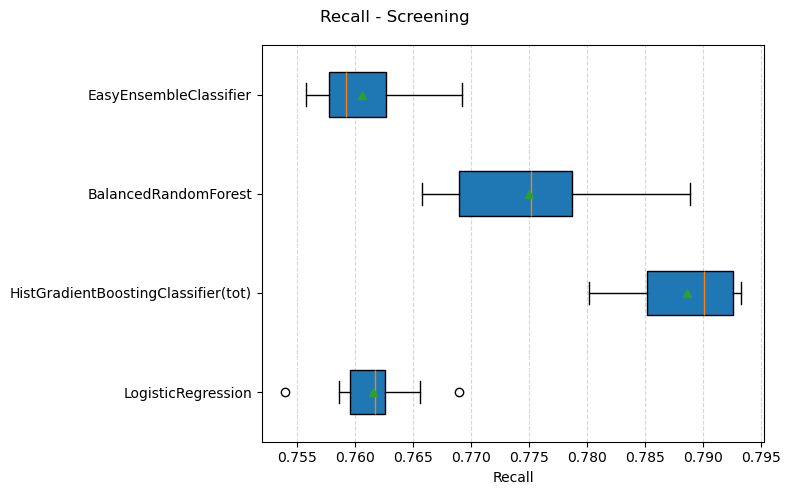

In [35]:
mcc_data = [res['test_mcc'] for res in results]
# plotting MCC
fig = plt.figure(figsize=(8, 5))
fig.suptitle("MCC - Screening")
ax = fig.add_subplot(111)
plt.boxplot(mcc_data, vert=False, labels=names, showmeans=True, patch_artist=True)
ax.set_xlabel('MCC Score')
ax.grid(True, axis='x', linestyle='--', alpha=0.5) 
plt.tight_layout()
plt.show()


recall_data = [res['test_recall_disease'] for res in results]
# plotting Recall
fig = plt.figure(figsize=(8, 5))
fig.suptitle("Recall - Screening")
ax = fig.add_subplot(111)
plt.boxplot(recall_data, vert=False, labels=names, showmeans=True, patch_artist=True)
ax.set_xlabel('Recall')
ax.grid(True, axis='x', linestyle='--', alpha=0.5) 
plt.tight_layout()
plt.show()

#### 3.Results healthy vs disease
The most important metric in this case is recall. 
EasyEnsembleClassifier was the worst performer.  
HistGradientBoosting was the best model for both recall and MCC, but I know from previous tests that it is a better at recalling diabetes patients than prediabetes.  
Logistic regression was outperformed but I know it is better for prediabetes than HistGradientBoosting.  
BalancedRandomForest was a good performer, and I know it is the best for recalling prediabetes.

I will therefore no longer consider the EasyEnsembleClassifier model and focus on the remaining 3.

#### 4. Considerations and final test
Considering this specific problem, In my opinion recalling prediabetics is more important than recalling diabetics.  
This is simply because prediabetes is a "silent" condition. People with prediabetes may not experience relevant symptoms, but if untreated, prediabetics will become full diabetic usually in a 5 year window.
Most importantly, prediabetes can (even if very rarely) be reversed, while diabetes cannot.  
Diabetes on the other hand is a morbid medical condition, and it is unlikely that someone is diabetic and does not know it already.  

In a real case scenario most diabetics are already diagnosed, while prediabetics are not. 
It is also very important to have decent healthy specificity to avoid predicting everybody as diseased.  
Therefore I will now consider prediabetic recall only, and use this metric to decide the final classifier.  

In [44]:
# split training set:

x_train, x_test, y_train, y_test = train_test_split(
    x_training, y_training, test_size=0.2, stratify=y_training, random_state=42
)

# create binary vector for training and testing
y_train_first = np.where(y_train <= 1 , y_train , 1)
y_test_first = np.where(y_test <= 1 , y_test , 1)

#### Performance at different thresholds

The models only see binary labels during training (healthy - disease).  
But I look at subclass (diabetes, prediabetes) recall.

In [50]:
# i will test different probability thresholds to recall more prediabetics as possible

thresholds = np.arange(0.1, 0.75, 0.05) # from 0.1 to 0.75 
models.pop("EasyEnsembleClassifier")


for name, model in models.items():
    print(f"\n{'='*20} {name} {'='*20}")
    
    # training on binary vector
    model.fit(x_train, y_train_first)
    
    # obtain class 1 probability
    probs_disease = model.predict_proba(x_test)[:, 1]
    
    print(f"{'threshold':<8} | {'Rec. PREDIABETICS':<20} | {'Rec. DIABETICS':<18} | {'Specificity HEALTHY'}")
    print("-" * 80)
    
    # threshold testing
    for t in thresholds:
        
        preds_custom = (probs_disease >= t).astype(int)

        # temporary data frame containing actual labels against binary classification        
        df_check = pd.DataFrame({'Real': y_test, 'Pred': preds_custom})
        
        # Recall prediabetics
        rec_pre = df_check[df_check['Real'] == 1]['Pred'].mean()
        
        # Recall diabetics
        rec_dia = df_check[df_check['Real'] == 2]['Pred'].mean()
        
        # Specificity
        spec = df_check[df_check['Real'] == 0]['Pred'].apply(lambda x: 1 if x==0 else 0).mean()

        marker = " <---" if rec_pre >= 0.90 else ""
        
        print(f"{t:.2f}     | {rec_pre:.4f}               | {rec_dia:.4f}             | {spec:.4f}{marker}")


==================== LogisticRegression ====================
threshold | Rec. PREDIABETICS    | Rec. DIABETICS     | Specificity HEALTHY
--------------------------------------------------------------------------------
0.10     | 0.9852               | 0.9961             | 0.1722 <---
0.15     | 0.9663               | 0.9871             | 0.2802 <---
0.20     | 0.9285               | 0.9742             | 0.3683 <---
0.25     | 0.8961               | 0.9547             | 0.4443
0.30     | 0.8489               | 0.9284             | 0.5120
0.35     | 0.7935               | 0.9001             | 0.5724
0.40     | 0.7557               | 0.8622             | 0.6255
0.45     | 0.7139               | 0.8255             | 0.6755
0.50     | 0.6613               | 0.7765             | 0.7248
0.55     | 0.5857               | 0.7229             | 0.7687
0.60     | 0.5142               | 0.6665             | 0.8089
0.65     | 0.4467               | 0.5892             | 0.8492
0.70     | 0.3671     

#### 5. Results
Logistic regression, Balanced Random forest and HistGradientBoosting had similar performance, but the best in my opinion is HistGradientBoosting because at threshold 0.2 we spot 91% of prediabetics and we correctly classify almost 41% of healthy people. The other models perform worse at similar recall.  


I finally found the first classifier to spot healthy vs unhealthy.

#### 6. Prediabetes vs diabetes classification